# 習熟度判定AIについて

実データを用いたデモ

# 目次

1. 目的
1. 概要
1. データセットについて
    1. データセット要約
    1. レコードのユニーク数
    1. データの前処理
1. パラメータ推定
1. 可視化
    1. 能力パラメータの可視化
    1. 項目パラメータの可視化
1. 推定結果と実データの比較
    1. 推定結果
    1. 実データ
    1. 比較
1. 結論

# 目的

本デモの目的は、習熟度判定に適用できる一つの手法「現代テスト理論」の効果と有効性を示す。

# 概要

「現代テスト理論」とは受験者の学習評価や指導内容と学習達成度の整合性などを分析し，試験問題の難易度や受験者の能力値といった特性を定量化する。現代テスト理論は1960年[^1]から数々の数学者や統計学者たちによって樹立されている。

現代テスト理論が示すものとしては**受験者の潜在能力**や**問題の難易度**等のパラメータがある。

[^1]: G. Rasch, Probalisitc models for some ubtekkegebce abd attaubnebt tests, Denmarks Paedogogiske Institute, 1960.

In [1]:
import numpy as np
import pandas as pd
import girth as irt
import matplotlib.pyplot as plt
import prettytable
import japanize_matplotlib

import IPython.display as display

plt.style.use("dark_background")

'''
use the following to show slides!

jupyter nbconvert notebooks/eda.ipynb --to slides --post serve --SlidesExporter.reveal_theme=night --HTMLExporter.theme=dark

'''

'\nuse the following to show slides!\n\njupyter nbconvert notebooks/eda.ipynb --to slides --post serve --SlidesExporter.reveal_theme=night --HTMLExporter.theme=dark\n\n'

In [2]:

def preprocess(dataframe):
    df = dataframe.copy()
    df = df.replace("s", 0)
    df["SAT Critical Reading Avg. Score"]  = pd.to_numeric(df["SAT Critical Reading Avg. Score"])
    df["SAT Math Avg. Score"]  = pd.to_numeric(df["SAT Math Avg. Score"])
    df["SAT Writing Avg. Score"]  = pd.to_numeric(df["SAT Writing Avg. Score"])
    df = df.drop(["SCHOOL NAME", "Num of SAT Test Takers", "DBN"], axis=1)
    
    return df, dataframe["SCHOOL NAME"]

def estimate_params(dataframe):
    df = dataframe.T
    results = irt.twopl_mml(df.values)
    ability = results["Ability"]
    difficulty = results["Difficulty"]
    discrimination = results["Discrimination"]
    
    return ability, difficulty, discrimination

def get_top_idx(array, top):
    array = np.argsort(array)[::-1]
    array = array[:top]
    return array

def compute_rankings(school_names, ranking_array):
    results = prettytable.PrettyTable(["　推定ランキング　", "学校名"])
    for rank, idx in enumerate(ranking_array):
        name = school_names[idx]
        ranking = rank + 1
        results.add_row((ranking, name))
    results.align["学校名"] = "r"
    return results

def plot_difficulty(difficulty, discrimination):
    difficulty[np.isnan(difficulty)] = 0
    tmp_list = []
    for k in range(3):
        tmp_list.append(difficulty[k].mean())
    
    fig, ax = plt.subplots(1, 2)
    fig.suptitle("項目パラメータ推定")
    ax = np.ravel(ax)
    
    ax[0].plot(tmp_list, "o--")
    ax[0].set_title("難易度")
    ax[0].set_ylabel(r"$b$")
    ax[0].tick_params(axis='y')
    
    # ax[1].plot(discrimination, "bo--")
    ax[1].plot(discrimination, "o--")
    ax[1].set_title("弁別力")
    ax[1].set_ylabel(r"$a$")
    ax[1].tick_params(axis='y')
    ax[1].set_ylim(0,10)
    plt.setp([ax[0], ax[1]], 
            xticks=[0, 1, 2], 
            xticklabels=["読解部分", "数理部分", "記述部分"],
            )
    
    fig.tight_layout()
    
def plot_user(ability):
    plt.title("能力パラメータ")
    plt.ylabel("能力")
    plt.xlabel("学校（計478校）")
    plt.plot(ability, "x")
    
def show_comparsion(table):
    _2012_ranking = [1, 3, 2, 30, 5, 4, 6, 17, 13, 31]
    table.add_column("2012実ランキング", _2012_ranking)
    display.display(table)
    
def plot_ICT(difficulty):
    difficulty[np.isnan(difficulty)] = 0
    tmp_list = []
    for k in range(3):
        tmp_list.append(difficulty[k].mean())
    
    def rasch_model(x, b):
        non = 1
        denon = 1 + np.exp(-1*(x - b))
        return non/denon

    x = np.arange(-10, 10)
    for i, b in enumerate(tmp_list):
        Pr = rasch_model(x, b)
        plt.plot(x, Pr, "o--", alpha=0.3, label=f"項目{i}")

    plt.legend()
    plt.ylabel("確率")
    plt.xlabel("能力")

    plt.show()  


# データセットについて


試験の成績について分析・評価する「現代テスト理論」の有効性を示すため、本デモは実試験データを用いる。

具体的にはアメリカのニューヨーク市[^2]が無料公開している2012年の同市のSAT[^3]（大学進学適性試験）試験結果[^4]を本デモのデータセットとして採用する。

[^2]: https://www1.nyc.gov/
[^3]: 日本のセンター試験のような試験
[^4]: https://opendata.cityofnewyork.us/

## データセット要約

今回用いられるデータについて確認する。
データの項目は下記の通りで、左から学校番号、学校名、受験者数、平均読解点数、平均数学点数、平均記述点数。

In [3]:
dataframe = pd.read_csv("../input/2012-sat-results-1.csv")
dataframe.head()

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355,404,363
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383,423,366
2,01M450,EAST SIDE COMMUNITY SCHOOL,70,377,402,370
3,01M458,FORSYTH SATELLITE ACADEMY,7,414,401,359
4,01M509,MARTA VALLE HIGH SCHOOL,44,390,433,384


## レコードのユニーク数

データセットのレコードのユニーク数は下記の通り。
学校名 (SCHOOL NAME)のユニーク数が478であることから、今回のデータセットには478校のレコードがあることが分かる。

In [4]:
display.display(f"学校名のユニーク数: {dataframe['SCHOOL NAME'].nunique()}")

'学校名のユニーク数: 478'

In [5]:
display.display(f"学校名のユニーク数: {dataframe['SCHOOL NAME'].nunique()}")

'学校名のユニーク数: 478'

## データの前処理

現代テスト理論アルゴリズムに入力するため、データ型の変更や欠損値の処理などの前処理を行う必要がる。

In [6]:
df, school_names = preprocess(dataframe)
df.head()

,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score
0,355,404,363
1,383,423,366
2,377,402,370
3,414,401,359
4,390,433,384


# パラメータ推定

現代テスト理論をPythonにて実装し、データセットに対して受験者の習熟度・能力や問題の難易度などを推定する。

In [7]:
#　能力　　　難易度　　　 問題の弁別力
ability, difficulty, discrimination = estimate_params(df)

今回のデータセットは項目が３つあり、受験社が478校がある。
推定したパラメータがそれと一致することかを確認する。以下の結果から、データセットにある全学校の能力と、３つの項目の難易度と弁別力が推定されたことが分かった。

In [8]:
print(f"　能力レコード数：{len(ability):>5} (受験者数)")
print(f"難易度レコード数：{len(difficulty):>5} (項目数)")
print(f"弁別力レコード数：{len(discrimination):>5} (項目数)")

　能力レコード数：  478 (受験者数)
難易度レコード数：    3 (項目数)
弁別力レコード数：    3 (項目数)


# 可視化

推定したパラメータをプロットで可視化し、可視化する。

## 能力パラメータの可視化

下の図から能力が高い学校が少数存在し、一番多い部分を占めるのが平均能力の持った学校が分かった。

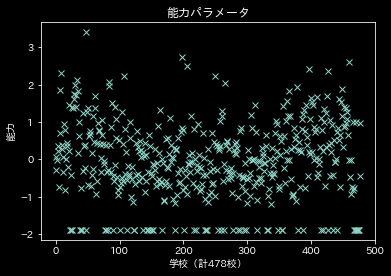

In [9]:
plot_user(ability)

(array([57.,  0.,  0.,  0.,  0.,  0.,  3.,  8., 12.,  8., 17., 20., 15.,
        29., 21., 19., 16., 25., 15., 20., 23., 26., 12., 14., 14., 17.,
         9., 13., 10.,  7., 10.,  8.,  4.,  5.,  2.,  4.,  3.,  3.,  2.,
         1.,  2.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([-1.87317799, -1.76760742, -1.66203686, -1.55646629, -1.45089572,
        -1.34532516, -1.23975459, -1.13418402, -1.02861346, -0.92304289,
        -0.81747232, -0.71190175, -0.60633119, -0.50076062, -0.39519005,
        -0.28961949, -0.18404892, -0.07847835,  0.02709221,  0.13266278,
         0.23823335,  0.34380391,  0.44937448,  0.55494505,  0.66051562,
         0.76608618,  0.87165675,  0.97722732,  1.08279788,  1.18836845,
         1.29393902,  1.39950958,  1.50508015,  1.61065072,  1.71622129,
         1.82179185,  1.92736242,  2.03293299,  2.13850355,  2.24407412,
         2.34964469,  2.45521525,  2.56078582,  2.66635639,  2.77192695,
         2.87749752,  2.98306809,  3.08863866,  3.19420922,

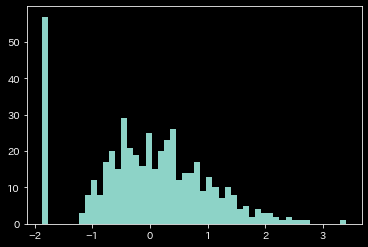

In [10]:
plt.hist(ability, bins=50)

## 項目パラメータの可視化

下の図から数理部分が一番難しいであり、読解が一番簡単であることが分かった。
一方、読解・数理・記述は受験者の能力を見分ける力（弁別力）においては差は微小である。

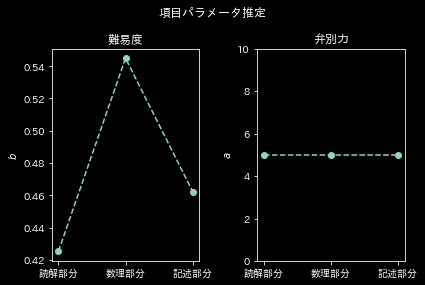

In [11]:
plot_difficulty(difficulty, discrimination)

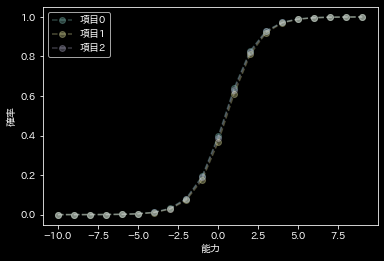

In [12]:
plot_ICT(difficulty)

# 推定結果と  
# 実データの対照

試験データから推定した能力パラメータを用いて学校のランキングを構成し、2019年のニューヨーク市の高校ランキングのデータと比較する

## 推定結果

学校の能力を高い順に並べ、トップ10校の算出する。

In [13]:
top_10_idx = get_top_idx(ability, 10)
results = compute_rankings(school_names, top_10_idx)
display.display(results)

推定ランキング,学校名
1,STUYVESANT HIGH SCHOOL
2,BRONX HIGH SCHOOL OF SCIENCE
3,STATEN ISLAND TECHNICAL HIGH SCHOOL
4,HIGH SCHOOL OF AMERICAN STUDIES AT LEHMAN COLLEGE
5,TOWNSEND HARRIS HIGH SCHOOL
6,QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK COLLEGE
7,BARD HIGH SCHOOL EARLY COLLEGE
8,"HIGH SCHOOL FOR MATHEMATICS, SCIENCE AND ENGINEERING AT CITY COLLEGE"
9,BROOKLYN TECHNICAL HIGH SCHOOL
10,ELEANOR ROOSEVELT HIGH SCHOOL


## 実データ

2012年のデータの用いて、USニューズ&ワールド・レポートが発表したニューヨーク市の高校ランキングと比較する。

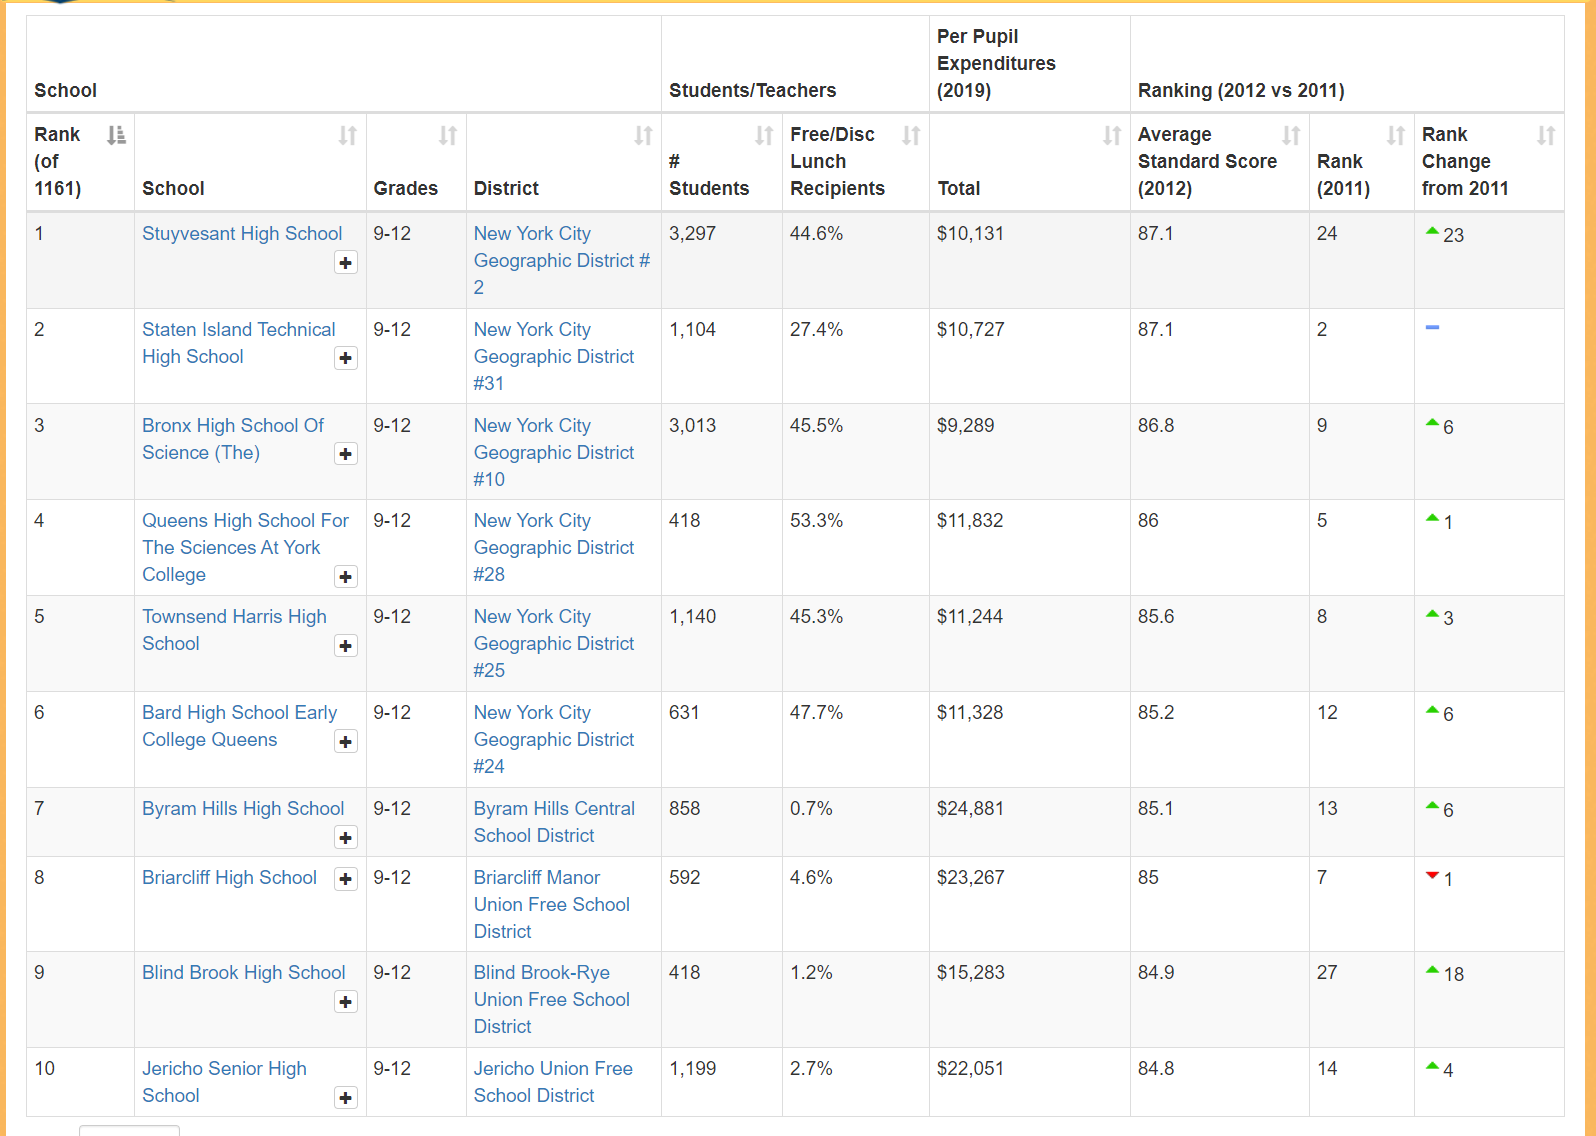

In [14]:
src = "../html/NYC_HS_rankings_2012.PNG"
#  https://www.schooldigger.com/go/NY/schoolrank.aspx?level=3
display.Image(src, width=800, height=600)

## 比較

下の表で表した通り、今回受験者の能力を評価するためのアルゴリズムは、実データと比較し、非常に高い精度を示している。

いくつかズレている学校はあるが、それらはいずれも誤差７％以下のものでして、モデルのチューニングなどを考慮し、非常に高い精度だと考えられる。

In [15]:
show_comparsion(results)

推定ランキング,学校名,2012実ランキング
1,STUYVESANT HIGH SCHOOL,1
2,BRONX HIGH SCHOOL OF SCIENCE,3
3,STATEN ISLAND TECHNICAL HIGH SCHOOL,2
4,HIGH SCHOOL OF AMERICAN STUDIES AT LEHMAN COLLEGE,30
5,TOWNSEND HARRIS HIGH SCHOOL,5
6,QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK COLLEGE,4
7,BARD HIGH SCHOOL EARLY COLLEGE,6
8,"HIGH SCHOOL FOR MATHEMATICS, SCIENCE AND ENGINEERING AT CITY COLLEGE",17
9,BROOKLYN TECHNICAL HIGH SCHOOL,13
10,ELEANOR ROOSEVELT HIGH SCHOOL,31


# 結論

本デモはニューヨーク市の2012年高校試験データを用いて、現代テスト理論を基づいて学校ランキングを推定した。

具体的には試験結果から学校の能力値を推定し、その能力値を高い順に並べ、ランキングを作成した。

結果として2012年の実ランキングと比較し、精度が非常に高いことを示して能力値の推定において現代テスト理論は有効性であることを示した。

以上の結果を踏まえ、受験者の能力を意味する「習熟度」に対しても、現代テスト理論は適切であることが考えられる。